In [31]:
import numpy as np
import itertools as it
from scipy.special import gamma
from scipy.special import multigammaln

def BHC_vanilla(data, likelihood, alpha):
    """`
    Bayesian hierarchical clustering algorithm, direct implementation from paper.
    
    Parameters
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    likelihood : function
        Function that returns the marginal likelihood of data in BHC model.
    alpha : float
        Concentration parameter in model.
        
    Returns
    -------
    T_record : list(list(int))
        Cluster structure in each iteration.
    rk_record : list(float)
        Merge probability (rk) in each iteration.
    """
    
    n = data.shape[0]
    p = data.shape[1]
    c = n
    D = dict((index, Node(obs.reshape(-1, p), alpha)) for index, obs in enumerate(data))
    T = list(range(n))
    T_record = list(T)
    rk_record = [1]
    
    while c > 1:
        max_rk = float('-Inf')
        node_merge = None
        left_merge = -1
        right_merge = -1
        
        for i, j in it.combinations(D.keys(), 2):
            Di = D[i]
            Dj = D[j]
            Dk = Node.merge_node(Di, Dj)
            
            likelihood_i = likelihood(Di.data)
            likelihood_j = likelihood(Dj.data)
            likelihood_k = likelihood(Dk.data)
            
            pi_k = Dk.pi_k

            rk = (pi_k * likelihood_k) / (pi_k * likelihood_k + (1 - pi_k) * likelihood_i * likelihood_j)

            if rk > max_rk:
                max_rk = rk
                node_merge = Dk
                left_merge = i
                right_merge = j
        
        #delete merged nodes and store new node
        del D[right_merge]
        D[left_merge] = node_merge

        #store the current tree structure and value of rk
        for item_index, node_index in enumerate(T):
            if node_index == right_merge:
                T[item_index] = left_merge
        T_record.append(list(T))
        rk_record.append(max_rk)
        
        c -= 1
        
    return T_record, rk_record
        

class Node(object):
    """
    Node class used in Bayesian hierarchical clustering algorithm. Main purpose is to store values of dk and pi_k for each node.
    
    Attributes
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    dk : float
        Some kind of number for computing probabilities
    pi_k : float
        For to compute merge probability
        
    Methods
    -------
    __init__(self, data, likelihood, alpha = 1)
        Instantiation operation.
    merge_node(cls, node1, node2, alpha = 1)
        Method that merges two Nodes into one new Node and return the new Node.
    """
    
    def __init__(self, data, alpha = 1, dk = 1, pi_k = 1):
        """
        Instantiation operation.
        
        Parameters
        ----------
        data : 2D numpy array
            Data with rows as observations and columns as variables.
        likelihood : function
            Function that returns the likelihood of data, sampling distribution in BHC model.
        alpha : float
            Concentration parameter in model.
        log_dk : float
            Cached probability variable. Do not define if the node is a leaf.
        log_pi : float
            Cached probability variable. Do not define if the node is a leaf.
        """
        
        #initialized according to paper
        self.data = data
        self.dk = dk
        self.pi_k = pi_k

    @classmethod
    def merge_node(cls, node1, node2, alpha = 1):
        """
        Merge two Nodes into one new Node and return the new Node.
        
        Parameters
        ----------
        node1 : Node
            First Node.
        node2 : Node
            Second Node.
        """

        data = np.vstack((node1.data, node2.data))

        nk = data.shape[0]
        dk = alpha * gamma(nk) + node1.dk * node2.dk
        pi_k = alpha * gamma(nk) / dk

        return cls(data, alpha, dk, pi_k)

In [44]:
from scipy.stats import multivariate_normal
def Multinorm_post_marginal_likelihood(mu_0, kappa_0, nu_0, Psi_0):
    """
    Returns a function that computes the marginal likelihood 
    for a Normal-inverse-Wishart model with specifies data and prior parameters.
    """
        
    def marginal_likelihood(data):
        
        n = data.shape[0]
        p = data.shape[1]
        xbar = data.mean(axis = 0)
    
        #update posterior parameters
        kappa_n = kappa_0 + n
        mu_n = (kappa_0 * mu_0 + n * xbar) / kappa_n
        nu_n = nu_0 + n
    
        if (n == 1):
            C = np.zeros((p, p))
        else:
            C = (n - 1) * np.cov(data.T)
        Psi_n = Psi_0 + C + ((n * kappa_0) / (kappa_n)) * np.dot((xbar - mu_0).reshape(-1, p).T, (xbar - mu_0).reshape(-1, p))
    
        return (1 / np.pi**(n * p / 2)) * (np.exp(multigammaln(nu_n / 2, p)) / np.exp(multigammaln(nu_0 / 2, p))) * (np.linalg.det(Psi_0)**(nu_0 / 2) / np.linalg.det(Psi_n)**(nu_n / 2)) * (kappa_0 / kappa_n)**(p / 2)

    return marginal_likelihood

In [50]:
n = 10
y1 = np.random.multivariate_normal([0, 0], np.eye(2) * 0.1, n)
y2 = np.random.multivariate_normal([5, 0], np.eye(2) * 0.3, n)
y3 = np.random.multivariate_normal([0, 5], np.eye(2) * 0.5, n)
y4 = np.random.multivariate_normal([-5, 5], np.eye(2) * 0.7, n)
y5 = np.random.multivariate_normal([0, -5], np.eye(2) * 0.9, n)
data = np.vstack((y1, y2, y3, y4, y5))

likelihood = Multinorm_post_marginal_likelihood(mu_0 = np.zeros(2), kappa_0 = 1, nu_0 = 2 + 1, Psi_0 = np.eye(2))

clusters, rks = BHC_vanilla(data, likelihood, 1)
clust_n = next(x for x, val in enumerate(rks) if val < 0.5)

In [34]:
clust_n = data.shape[0] - next(x for x, val in enumerate(rks) if val < 0.5) + 1
clust_n

5

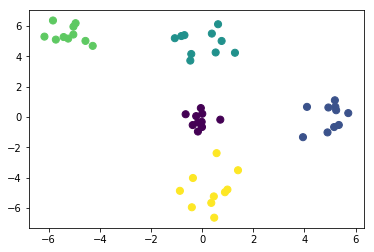

In [35]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c = clusters[-clust_n], s = 50)
plt.show()

Cython

In [13]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [48]:
%%cython -a

import numpy as np
import itertools as it
from scipy.special import gamma
from scipy.special import multigammaln
from numpy.math cimport INFINITY
cimport numpy as np


def BHC_cython(data, likelihood, alpha):
    """`
    Bayesian hierarchical clustering algorithm, direct implementation from paper.
    
    Parameters
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    likelihood : function
        Function that returns the marginal likelihood of data in BHC model.
    alpha : float
        Concentration parameter in model.
        
    Returns
    -------
    T_record : list(list(int))
        Cluster structure in each iteration.
    rk_record : list(float)
        Merge probability (rk) in each iteration.
    """
    
    cdef int n, c, i, j
    cdef float max_rk
    cdef int merge_index1, merge_index2
    cdef double pi_k, rk
    cdef int node_index, item_index
    cdef double likelihood_i, likelihood_j, likelihood_k
    cdef T_record, rk_record
    
    n = data.shape[0]
    p = data.shape[1]
    c = n
    D = dict((index, Node(obs.reshape(-1, p), alpha)) for index, obs in enumerate(data))
    T = list(range(n))
    T_record = list(T)
    rk_record = [1]
    
    while c > 1:
        max_rk = -INFINITY
        node_merge = None
        left_merge = -1
        right_merge = -1
        
        for i, j in it.combinations(D.keys(), 2):
            Di = D[i]
            Dj = D[j]
            Dk = Node.merge_node(Di, Dj)
            
            likelihood_i = likelihood(Di.data)
            likelihood_j = likelihood(Dj.data)
            likelihood_k = likelihood(Dk.data)
            
            pi_k = Dk.pi_k

            rk = (pi_k * likelihood_k) / (pi_k * likelihood_k + (1 - pi_k) * likelihood_i * likelihood_j)

            if rk > max_rk:
                max_rk = rk
                node_merge = Dk
                left_merge = i
                right_merge = j
        
        #delete merged nodes and store new node
        del D[right_merge]
        D[left_merge] = node_merge

        #store the current tree structure and value of rk
        for item_index, node_index in enumerate(T):
            if node_index == right_merge:
                T[item_index] = left_merge
        T_record.append(list(T))
        rk_record.append(max_rk)
        
        c -= 1
        
    return T_record, rk_record
        

class Node(object):
    """
    Node class used in Bayesian hierarchical clustering algorithm. Main purpose is to store values of dk and pi_k for each node.
    
    Attributes
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    dk : float
        Some kind of number for computing probabilities
    pi_k : float
        For to compute merge probability
        
    Methods
    -------
    __init__(self, data, likelihood, alpha = 1)
        Instantiation operation.
    merge_node(cls, node1, node2, alpha = 1)
        Method that merges two Nodes into one new Node and return the new Node.
    """
    
    def __init__(self, data, alpha = 1, dk = 1, pi_k = 1):
        """
        Instantiation operation.
        
        Parameters
        ----------
        data : 2D numpy array
            Data with rows as observations and columns as variables.
        likelihood : function
            Function that returns the likelihood of data, sampling distribution in BHC model.
        alpha : float
            Concentration parameter in model.
        log_dk : float
            Cached probability variable. Do not define if the node is a leaf.
        log_pi : float
            Cached probability variable. Do not define if the node is a leaf.
        """
        
        #initialized according to paper
        self.data = data
        self.dk = dk
        self.pi_k = pi_k

    @classmethod
    def merge_node(cls, node1, node2, alpha = 1):
        """
        Merge two Nodes into one new Node and return the new Node.
        
        Parameters
        ----------
        node1 : Node
            First Node.
        node2 : Node
            Second Node.
        """

        cdef np.ndarray[dtype = double, ndim = 2] data
        cdef double nk
        
        data = np.vstack((node1.data, node2.data))

        nk = data.shape[0]
        dk = alpha * gamma(nk) + node1.dk * node2.dk
        pi_k = alpha * gamma(nk) / dk

        return cls(data, alpha, dk, pi_k)

In [55]:
n = 10
y1 = np.random.multivariate_normal([0, 0], np.eye(2) * 0.1, n)
y2 = np.random.multivariate_normal([5, 0], np.eye(2) * 0.3, n)
y3 = np.random.multivariate_normal([0, 5], np.eye(2) * 0.5, n)
y4 = np.random.multivariate_normal([-5, 5], np.eye(2) * 0.7, n)
y5 = np.random.multivariate_normal([0, -5], np.eye(2) * 0.9, n)
data = np.vstack((y1, y2, y3, y4, y5))

likelihood = Multinorm_post_marginal_likelihood(mu_0 = np.zeros(2), kappa_0 = 1, nu_0 = 2 + 1, Psi_0 = np.eye(2))

clusters, rks = BHC_cython(data, likelihood, 1)
clust_n = next(x for x, val in enumerate(rks) if val < 0.5)

In [56]:
clust_n = data.shape[0] - next(x for x, val in enumerate(rks) if val < 0.5) + 1
clust_n

5

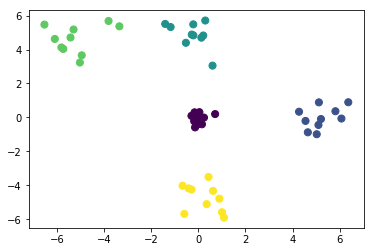

In [57]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c = clusters[-clust_n], s = 50)
plt.show()

In [36]:
%timeit -r3 -n1 BHC_vanilla(data, likelihood, 1)

22.5 s ± 79.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [49]:
%timeit -r3 -n1 BHC_cython(data, likelihood, 1)

22.5 s ± 105 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
